# 1. Import libraries, import medsam checkpoint and define H, W, batch size

In [1]:
import os
import shutil
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import nibabel as nib
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torchmetrics.classification import BinaryJaccardIndex, Dice
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torchvision

# %% environment and functions
import matplotlib.pyplot as plt
join = os.path.join
from segment_anything import sam_model_registry
from skimage import io, transform


In [2]:
H = 240
W = 240
BATCH_SIZE = 1

In [6]:
#%% load model and image
MedSAM_CKPT_PATH = "/kaggle/working/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [4]:
# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2024-04-15 17:15:33--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: 'medsam_vit_b.pth'

medsam_vit_b.pth    100%[===================>] 357.67M  14.4MB/s    in 1m 51s  

2024-04-15 17:17:24 (3.23 MB/s) - 'medsam_vit_b.pth' saved [375049145/375049145]



# 2. Define Dataset Class, load data

In [7]:
class BraTSDataset(Dataset):    
    def __init__(self, data_root_folder, folder = '', n_sample=None):
        main_folder = os.path.join(data_root_folder, folder)
        self.folder_path = os.path.join(main_folder, 'slice')

    def __getitem__(self, index):
        file_name = os.listdir(self.folder_path)[index]
        sample = torch.from_numpy(np.load(os.path.join(self.folder_path, file_name)))
        img_as_tensor = np.expand_dims(sample[0,:,:], axis=0)
        mask_as_tensor = np.expand_dims(sample[1,:,:], axis=0)
        return {
            'image': img_as_tensor,
            'mask': mask_as_tensor,
            'img_id': file_name
        }
 
    def __len__(self):
        return len(os.listdir(self.folder_path))

## Load Dataset

In [8]:
data_root_folder = '/kaggle/input/full_raw - Copy'
train_dataset = BraTSDataset(data_root_folder = data_root_folder, folder = 'train')
val_dataset = BraTSDataset(data_root_folder = data_root_folder, folder = 'val')
test_dataset = BraTSDataset(data_root_folder = data_root_folder, folder = 'test')

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Define medsam, mask and bounding box functions

## Self-defined functions

In [11]:
def convert_to_binary(arr):
    return np.where(arr > 0, 1, 0)

In [12]:
def visualize_masks(nii_img):
    nii_aff  = nii_img.affine
    nii_hdr  = nii_img.header

    # print(nii_aff ,'\n',nii_hdr)
    # print(nii_data.shape)
    nii_data = nii_img.get_fdata()
    number_of_slices = nii_data.shape[1]
    number_of_frames = nii_data.shape[2]
    number_of_frames = 1

    # Define the number of columns for subplot
    num_columns = 5

    if(len(nii_data.shape)==3):
        start_slice = 80
        end_slice = 100
        num_slices = end_slice - start_slice + 1
        num_rows = num_slices // num_columns + 1

        fig, ax = plt.subplots(num_rows, num_columns, figsize=(10,10))

        for i in range(start_slice, end_slice+1):
            row = (i-start_slice) // num_columns
            col = (i-start_slice) % num_columns
            ax[row, col].imshow(nii_data[:,:,i])
            ax[row, col].axis('off')

        # Remove empty subplots
        for j in range(i-start_slice+1, num_rows*num_columns):
            fig.delaxes(ax.flatten()[j])

        plt.show()

In [13]:
def box_coordinates_from_mask_batch(batch_mask, margin = 5):
    # Works on [240, 240]
    # Modify for this to work on [16, 1, 240, 240]
    counter = 0
    box_1024_batch = []
    useless_image_indices = []
    for ind, mask in enumerate(batch_mask):
#         print("mask shape", mask.shape)
        mask = mask[0]
#         print("mask shape 2", mask.shape)
        nonzero_indices = torch.nonzero(mask).T
#         print("nonzero_indices shape:", nonzero_indices.shape)
#         nonzero_indices = torch.transpose(torch.nonzero(mask).T)
        if nonzero_indices.shape[-1] == 0:
            useless_image_indices.append(ind)
            box_1024 = torch.asarray([[-1, -1, -1, -1]])
#             x0 = 0
#             y0 = 0
#             x1 = 
        else:
            min_y = torch.min(nonzero_indices[0, :])
            max_y = torch.max(nonzero_indices[0, :])
            min_x = torch.min(nonzero_indices[1, :])
            max_x = torch.max(nonzero_indices[1, :])

            margin = 5

            x0 = min_x - margin
            y0 = min_y - margin
            x1 = max_x + margin
            y1 = max_y + margin

            # print(f"Row and column for non-zero elements with greatest x range: [{min_x}, {max_x}]")
            # print(f"Row and column for non-zero elements with greatest y range: [{min_y}, {max_y}]")

            box_np = torch.asarray([[x0,y0, x1, y1]])
            box_1024 = box_np / torch.asarray([W, H, W, H]) * 1024
#         print("box 1024 shape", box_1024.shape)
        box_1024_batch.append(box_1024)

    if counter == BATCH_SIZE:
        return         
        
    final_tensor = torch.cat(box_1024_batch, dim = 0)
    final_tensor = final_tensor.unsqueeze(dim = 1)

#     print(final_tensor.shape)
    return final_tensor, useless_image_indices

## MedSAM functions

In [14]:
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    # print("x_0, y_0", x0, y0)
    # print("w, h", w, h)
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

In [15]:
def generate_box_and_embedding(img, img_mask):
    H = 240
    W = 240

    #%% image preprocessing part 2
    resizer = torchvision.transforms.Resize(size = (1024,1024))
    img_1024 = resizer(img)
#     print("img_1024 shape: ", img_1024.shape)

    # generate boxes and useless image indices
    box_1024, useless_image_indices = box_coordinates_from_mask_batch(img_mask)
#     print(img_1024.shape)

    # generate negated splicer
    useful_indices = torch.ones(BATCH_SIZE, dtype=bool)
    for index in useless_image_indices:
        useful_indices[index] = False
#     negated_splicer = ~splicer
    
#     img_1024 = img_1024.repeat(1, 3, 1, 1)
    
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024) # (1, 256, 64, 64)
#     print("image_embedding shape", image_embedding.shape)
#     print("box_1024 shape", box_1024.shape)
    return image_embedding, box_1024, useful_indices

In [16]:
test = torch.Tensor([1,2,3])
test[[False,False, True]]

tensor([3.])

In [17]:
# Medsam inference code
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
#     if len(box_torch.shape) == 2:
#         box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

# 4. Training loop

In [18]:
def all_false(lst):
    return all(element == False for element in lst)

In [ ]:
print(len(val_dataloader))

In [ ]:
print(BATCH_SIZE)

In [65]:
# Training loop
# Initialize metrics and metrics lists
from time import time
start_time = time()
valid_batch_dice = []
valid_batch_jaccard = []
dice_metric = Dice()
jaccard_index_metric = BinaryJaccardIndex()
# [B, C, 240, 240]
# [C, 240, 240]
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_dataloader)):
        print("Iteration nb: ", i)
        if i%100 == 99:
            print("Iteration nb: ", i)
            print("Elapsed time:", time() - start_time)
#         print("Iteration ", i)
        # get image and masks from dataloader, change nb channels = 3
        imgs = batch['image'].to(device).float()
        img_masks = batch['mask'] #.to(device).float()
        imgs = imgs.repeat(1, 3, 1, 1)
#         img_masks = img_masks.repeat(1, 3, 1, 1)
        # get non-empty image embeddings, bounding boxes and masks (i.e. labels)
        image_embedding, box_1024, useful_indices = generate_box_and_embedding(imgs, img_masks)
        if all_false(useful_indices):
            continue
        useful_box_1024 = box_1024[useful_indices,:,:][0]
        useful_image_embedding = image_embedding[useful_indices,:,:,:][0]
        y_true = img_masks[useful_indices,:,:,:][0]
        useful_imgs = imgs[useful_indices,:,:,:][0]
        
#         print("image embedding shape", useful_image_embedding.shape)
#         print("box shape", useful_box_1024.shape)
#         print("mask shape", y_true.shape)

        # generate predictions using medsam_inference
#         print(medsam_pred.shape)
        output = medsam_inference(medsam_model, useful_image_embedding, useful_box_1024, H, W)
        y_pred = torch.from_numpy(output).unsqueeze(dim=0)
#         y_pred = net(imgs).cpu()
        
#         print("preds shape", y_pred.shape)
#         print("mask shape", y_true.shape)
        #TODO remove
#         y_true = y_true[0]
        print(torch.unique(y_pred))
        print(torch.unique(y_true))
        
        batch_dice_score = dice_metric(y_pred, y_true)
        print("Dice", batch_dice_score)
        valid_batch_dice.append(batch_dice_score)
    
        batch_jaccard_score = jaccard_index_metric(y_pred, y_true)
        print("Jaccard", batch_jaccard_score)
        valid_batch_jaccard.append(batch_jaccard_score)

#         print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {loss.item()}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}', end='\r')

  0%|          | 0/28985 [00:00<?, ?it/s]

Iteration nb:  0
Iteration nb:  1
tensor([0, 1], dtype=torch.uint8)
tensor([0, 1], dtype=torch.int16)
Dice tensor(0.9900)
Jaccard tensor(0.5152)
Iteration nb:  2
tensor([0, 1], dtype=torch.uint8)
tensor([0, 1], dtype=torch.int16)
Dice tensor(0.9832)
Jaccard tensor(0.5776)
Iteration nb:  3
Iteration nb:  4
Iteration nb:  5
Iteration nb:  6
Iteration nb:  7
tensor([0, 1], dtype=torch.uint8)
tensor([0, 1], dtype=torch.int16)
Dice tensor(0.9803)
Jaccard tensor(0.6029)
Iteration nb:  8
Iteration nb:  9
Iteration nb:  10
Iteration nb:  11
Iteration nb:  12
tensor([0, 1], dtype=torch.uint8)
tensor([0, 1], dtype=torch.int16)
Dice tensor(0.9928)
Jaccard tensor(0.5741)
Iteration nb:  13
tensor([0, 1], dtype=torch.uint8)
tensor([0, 1], dtype=torch.int16)
Dice tensor(0.9616)
Jaccard tensor(0.5927)
Iteration nb:  14
Iteration nb:  15
Iteration nb:  16
tensor([0, 1], dtype=torch.uint8)
tensor([0, 1], dtype=torch.int16)
Dice tensor(0.9688)
Jaccard tensor(0.4906)
Iteration nb:  17
tensor([0, 1], dtype

KeyboardInterrupt: 

  0%|          | 0/28985 [00:00<?, ?it/s]

Iteration nb:  0
Iteration nb:  1
Dice tensor(0.9900)
Jaccard tensor(0.5152)
Iteration nb:  2
Dice tensor(0.9832)
Jaccard tensor(0.5776)
Iteration nb:  3
Iteration nb:  4
Iteration nb:  5
Iteration nb:  6
Iteration nb:  7
Dice tensor(0.9803)
Jaccard tensor(0.6029)
Iteration nb:  8
Iteration nb:  9
Iteration nb:  10
Iteration nb:  11
Iteration nb:  12
Dice tensor(0.9928)
Jaccard tensor(0.5741)
Iteration nb:  13
Dice tensor(0.9616)
Jaccard tensor(0.5927)
Iteration nb:  14
Iteration nb:  15
Iteration nb:  16
Dice tensor(0.9688)
Jaccard tensor(0.4906)
Iteration nb:  17
Dice tensor(0.9898)
Jaccard tensor(0.5443)
Iteration nb:  18
Iteration nb:  19
Dice tensor(0.9925)
Jaccard tensor(0.7403)
Iteration nb:  20
Iteration nb:  21
Iteration nb:  22
Iteration nb:  23
Iteration nb:  24
Iteration nb:  25
Iteration nb:  26
Iteration nb:  27
Iteration nb:  28
Dice tensor(0.9953)
Jaccard tensor(0.5298)
Iteration nb:  29
Dice tensor(0.9882)
Jaccard tensor(0.7494)


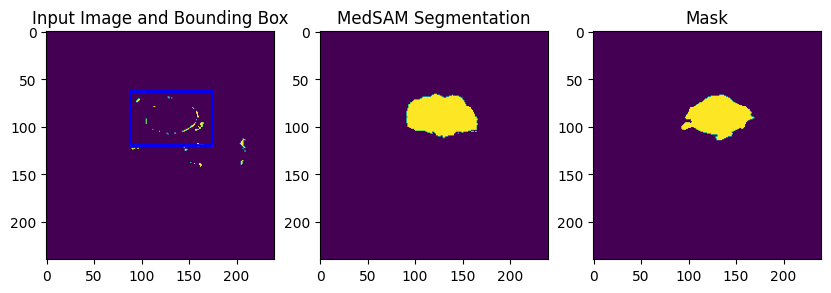

In [43]:
# Dice tensor(0.9882)
# Jaccard tensor(0.7494)

# Training loop
# Initialize metrics and metrics lists
from time import time
start_time = time()
valid_batch_dice = []
valid_batch_jaccard = []
dice_metric = Dice()
jaccard_index_metric = BinaryJaccardIndex()
# [B, C, 240, 240]
# [C, 240, 240]
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_dataloader)):
        print("Iteration nb: ", i)
        if i%100 == 99:
            print("Iteration nb: ", i)
            print("Elapsed time:", time() - start_time)
#         print("Iteration ", i)
        # get image and masks from dataloader, change nb channels = 3
        imgs = batch['image'].to(device).float()
        img_masks = batch['mask'] #.to(device).float()
        imgs = imgs.repeat(1, 3, 1, 1)
#         img_masks = img_masks.repeat(1, 3, 1, 1)
        # get non-empty image embeddings, bounding boxes and masks (i.e. labels)
        image_embedding, box_1024, useful_indices = generate_box_and_embedding(imgs, img_masks)
        if all_false(useful_indices):
            continue
        useful_box_1024 = box_1024[useful_indices,:,:][0]
        useful_image_embedding = image_embedding[useful_indices,:,:,:][0]
        y_true = img_masks[useful_indices,:,:,:][0]
        useful_imgs = imgs[useful_indices,:,:,:][0]
        
#         print("image embedding shape", useful_image_embedding.shape)
#         print("box shape", useful_box_1024.shape)
#         print("mask shape", y_true.shape)

        # generate predictions using medsam_inference
#         print(medsam_pred.shape)
        output = medsam_inference(medsam_model, useful_image_embedding, useful_box_1024, H, W)
        y_pred = torch.from_numpy(output).unsqueeze(dim=0)
#         y_pred = net(imgs).cpu()
        
#         print("preds shape", y_pred.shape)
#         print("mask shape", y_true.shape)
        #TODO remove
#         y_true = y_true[0]
        
        batch_dice_score = dice_metric(y_pred, y_true)
        print("Dice", batch_dice_score)
        valid_batch_dice.append(batch_dice_score)
    
        batch_jaccard_score = jaccard_index_metric(y_pred, y_true)
        print("Jaccard", batch_jaccard_score)
        valid_batch_jaccard.append(batch_jaccard_score)
        if i == 29:
            box_240 = useful_box_1024 / torch.asarray([1024, 1024, 1024, 1024]) * 240
            fig, ax = plt.subplots(1, 3, figsize=(10, 5))
            ax[0].imshow(imgs[0][0,:,:].cpu())
            show_box(box_240[0].numpy(), ax[0])
            ax[0].set_title("Input Image and Bounding Box")
            ax[1].imshow(y_pred[0])
            # show_mask(medsam_seg, ax[1])
            # show_box(box_np[0], ax[1])
            ax[1].set_title("MedSAM Segmentation")

            ax[2].imshow(y_true[0])
            ax[2].set_title("Mask")
            plt.show()        
            break            

#         print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {loss.item()}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}', end='\r')

In [64]:
# 16
# Dice tensor(0.9688)
# Jaccard tensor(0.4906)

# Training loop
# Initialize metrics and metrics lists
from time import time
start_time = time()
valid_batch_dice = []
valid_batch_jaccard = []
dice_metric = Dice()
jaccard_index_metric = BinaryJaccardIndex()
# [B, C, 240, 240]
# [C, 240, 240]
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_dataloader)):
        print("Iteration nb: ", i)
        if i%100 == 99:
            print("Iteration nb: ", i)
            print("Elapsed time:", time() - start_time)
#         print("Iteration ", i)
        # get image and masks from dataloader, change nb channels = 3
        imgs = batch['image'].to(device).float()
        img_masks = batch['mask'] #.to(device).float()
        imgs = imgs.repeat(1, 3, 1, 1)
#         img_masks = img_masks.repeat(1, 3, 1, 1)
        # get non-empty image embeddings, bounding boxes and masks (i.e. labels)
        image_embedding, box_1024, useful_indices = generate_box_and_embedding(imgs, img_masks)
        if all_false(useful_indices):
            continue
        useful_box_1024 = box_1024[useful_indices,:,:][0]
        useful_image_embedding = image_embedding[useful_indices,:,:,:][0]
        y_true = img_masks[useful_indices,:,:,:][0]
        useful_imgs = imgs[useful_indices,:,:,:][0]
        
#         print("image embedding shape", useful_image_embedding.shape)
#         print("box shape", useful_box_1024.shape)
#         print("mask shape", y_true.shape)

        # generate predictions using medsam_inference
#         print(medsam_pred.shape)
        output = medsam_inference(medsam_model, useful_image_embedding, useful_box_1024, H, W)
        y_pred = torch.from_numpy(output).unsqueeze(dim=0)
        print(j_d(y_pred, y_true))
#         y_pred = net(imgs).cpu()
        
#         print("preds shape", y_pred.shape)
#         print("mask shape", y_true.shape)
        #TODO remove
#         y_true = y_true[0]
        
#         batch_dice_score = dice_metric(y_pred, y_true)
#         intersect = x.intersection(y)

#         print("Dice", batch_dice_score)
#         valid_batch_dice.append(batch_dice_score)
    
#         batch_jaccard_score = jaccard_index_metric(y_pred, y_true)
#         print("Jaccard", batch_jaccard_score)
          
#         valid_batch_jaccard.append(batch_jaccard_score)
#         if i == 16:
#             box_240 = useful_box_1024 / torch.asarray([1024, 1024, 1024, 1024]) * 240
#             fig, ax = plt.subplots(1, 3, figsize=(10, 5))
#             ax[0].imshow(imgs[0][0,:,:].cpu())
#             show_box(box_240[0].numpy(), ax[0])
#             ax[0].set_title("Input Image and Bounding Box")
#             ax[1].imshow(y_pred[0])
#             # show_mask(medsam_seg, ax[1])
#             # show_box(box_np[0], ax[1])
#             ax[1].set_title("MedSAM Segmentation")

#             ax[2].imshow(y_true[0])
#             ax[2].set_title("Mask")
#             plt.show()        
#             break            

#         print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {loss.item()}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}', end='\r')

  0%|          | 0/28985 [00:00<?, ?it/s]

Iteration nb:  0
Iteration nb:  1
(0.9801980257034302, 0.9801980257034302)
Iteration nb:  2
(0.9669108390808105, 0.9669107794761658)
Iteration nb:  3
Iteration nb:  4
Iteration nb:  5
Iteration nb:  6
Iteration nb:  7
(0.9613852500915527, 0.9613853096961975)
Iteration nb:  8
Iteration nb:  9
Iteration nb:  10
Iteration nb:  11
Iteration nb:  12
(0.9857276082038879, 0.9857276082038879)
Iteration nb:  13
(0.9259704947471619, 0.9259705543518066)
Iteration nb:  14
Iteration nb:  15
Iteration nb:  16
(0.9395245313644409, 0.9395244717597961)
Iteration nb:  17
(0.9798576831817627, 0.9798577427864075)
Iteration nb:  18
Iteration nb:  19
(0.985077440738678, 0.9850775003433228)
Iteration nb:  20
Iteration nb:  21
Iteration nb:  22
Iteration nb:  23
Iteration nb:  24
Iteration nb:  25
Iteration nb:  26
Iteration nb:  27
Iteration nb:  28
(0.9907375574111938, 0.9907375574111938)
Iteration nb:  29
(0.9767661094665527, 0.976766049861908)
Iteration nb:  30
Iteration nb:  31
Iteration nb:  32
Iteratio

KeyboardInterrupt: 

In [60]:
def j_d(y_pred, y_true):
    num_intersection = (torch.sum(y_pred == y_true))
    total_num = 240 * 240
    j = num_intersection/(total_num * 2 - num_intersection)
    d = (2 * num_intersection)/(total_num * 2)
    perhaps_j = d/(2-d)
    return j.item(), perhaps_j.item()

In [61]:
j_d(y_pred, y_true)

(0.9767661094665527, 0.976766049861908)

In [44]:
j_d(y_pred, y_true)

(tensor(0.9768), tensor(0.9882))

In [32]:
print(y_pred.shape)

torch.Size([1, 240, 240])


In [31]:
num_elements

5190

In [ ]:
#%% visualize results
box_240 = useful_box_1024 / torch.asarray([1024, 1024, 1024, 1024]) * 240
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(useful_imgs[0].cpu())
show_box(box_240[0].numpy(), ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(y_pred[0])
# show_mask(medsam_seg, ax[1])
# show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")

ax[2].imshow(y_true[0])
ax[2].set_title("Mask")
plt.show()

In [ ]:
y_true

In [ ]:
y_pred

## Old code

In [ ]:
# # Training loop
# valid_batch_dice = []
# valid_batch_jaccard = []
# dice_metric = Dice()
# jaccard_index_metric = BinaryJaccardIndex()
# with torch.no_grad():
#     H = 240
#     W = 240
#     for i, batch in enumerate(tqdm(val_dataloader)):
#         # get image and masks from dataloader
#         imgs = batch['image'].to(device).float()
#         img_masks = batch['mask'] #.to(device).float()
#         imgs = imgs.repeat(1, 3, 1, 1)
#         img_masks = img_masks.repeat(1, 3, 1, 1)
        
#         # get useful image embeddings, bounding boxes and masks = labels
#         image_embedding, box_1024, useful_indices = generate_box_and_embedding(imgs, img_masks)
#         useful_box_1024 = box_1024[useful_indices,:,:]
#         useful_image_embedding = image_embedding[useful_indices,:,:,:]
#         y_true = img_masks[useful_indices,:,:,:]
        
#         print("image embedding shape", useful_image_embedding.shape)
#         print("box shape", useful_box_1024.shape)
#         print("mask shape", useful_img_masks.shape)

#         y_pred = torch.from_numpy(medsam_inference(medsam_model, useful_image_embedding, useful_box_1024, H, W))
# #         y_pred = net(imgs).cpu()
        
#         print("preds shape", y_pred.shape)
#         print("mask shape", y_true.shape)
#         #TODO remove
#         y_true = y_true[0][0]
        
#         batch_dice_score = dice_metric(y_pred, y_true)
#         print("Dice", batch_dice_score)
#         valid_batch_dice.append(batch_dice_score)

#         batch_jaccard_score = jaccard_index_metric(y_pred, y_true)
#         valid_batch_jaccard.append(batch_jaccard_score)

# #         print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {loss.item()}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}', end='\r')

In [ ]:
# def generate_box_and_embedding(img_np, mask_np):
# #     slice_indexes.append(slice_ind)
# #     if len(img_np.shape) == 2:
# #         img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
# #     else:
# #         img_3c = img_np
# #     H, W, _ = img_3c.shape
#     H = 240
#     W = 240

#     #%% image preprocessing part 2
#     # 16,1,1024,1024
#     resizer = torchvision.transforms.Resize(size = (1024,1024))
#     img_1024 = resizer(img_np)
# #     img_1024 = transform.resize(img_np, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
#     print("img_1024 shape: ", img_1024.shape)
# #     img_1024 = (img_1024 - img_1024.min()) / np.clip(
# #         img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
# #     )  # normalize to [0, 1], (H, W, 3)
# #     # convert the shape to (3, H, W)
# #     img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

#     # need to rewrite box coordinates from mask as input is now [16,1,240,240]
# #     x0, y0, x1, y1 = box_coordinates_from_mask(mask_np)
# #     box_np = np.array([[x0,y0, x1, y1]])
# #     box_1024 = box_np / np.array([W, H, W, H]) * 1024
#     box_1024, useless_image_indices = box_coordinates_from_mask_batch(mask_np)
#     print(img_1024.shape)
    
#     mask = torch.ones(BATCH_SIZE, dtype=bool)
#     for index in useless_image_indices:
#         mask[index] = False
#     # Negate the mask
#     negated_mask = ~mask
# #     print("negated mask", negated_mask)
# #     print("img_1024.shape", img_1024.shape)
#     filtered_img_1024_tensor = img_1024[negated_mask,:,:,:]    
    
#     filtered_img_1024_tensor_repeated = filtered_img_1024_tensor.repeat(1, 3, 1, 1)
#     print("filtered shape", filtered_img_1024_tensor.shape)
#     with torch.no_grad():
#         image_embedding = medsam_model.image_encoder(filtered_img_1024_tensor_repeated) # (1, 256, 64, 64)
#     print("image_embedding shape", image_embedding.shape)
#     print("box_1024 shape", box_1024.shape)
#     return image_embedding, box_1024, negated_mask

In [ ]:
def box_coordinates_from_mask(mask, margin = 5):
    # Works on [240, 240]
    # Modify for this to work on [16, 1, 240, 240]
    nonzero_indices = np.transpose(np.nonzero(mask))

    min_y = np.min(nonzero_indices[:, 0])
    max_y = np.max(nonzero_indices[:, 0])
    min_x = np.min(nonzero_indices[:, 1])
    max_x = np.max(nonzero_indices[:, 1])

    margin = 5

    x0 = min_x - margin
    y0 = min_y - margin
    x1 = max_x + margin
    y1 = max_y + margin

    # print(f"Row and column for non-zero elements with greatest x range: [{min_x}, {max_x}]")
    # print(f"Row and column for non-zero elements with greatest y range: [{min_y}, {max_y}]")
    
    box_np = np.array([[x0,y0, x1, y1]])
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    return box_1024